# STEP 2: From categorical to One-Hot Vector and Segmentation

From categorical to One-Hot Vector dataset and segmentations of the different training "folds"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Transformation

## Data Loading 

In [2]:
df = pd.read_csv('datasets/train_cleaned.csv', index_col='MachineIdentifier')

## Categorical Data Analysis 

In [3]:
columns_categorical = df.select_dtypes(include=['object']).columns

In [4]:
# Threshold of the size of different values of each categorical data
h_threshold = 350

In [5]:
total = 0
columns_to_partition = []
columns_to_onehot = []
for c in columns_categorical:
    values = df[c].nunique()
    suf = ""
    if (values > h_threshold):
        columns_to_partition.append(c)
        suf = ', PARTITION'
    else:
        columns_to_onehot.append(c)
    total += values
    print(c,': ',values,suf)
print('Total new vars: ' + str(total))

ProductName :  2 
EngineVersion :  57 
AppVersion :  101 
AvSigVersion :  6856 , PARTITION
Platform :  3 
Processor :  3 
OsVer :  33 
OsPlatformSubRelease :  9 
OsBuildLab :  418 , PARTITION
SkuEdition :  7 
SmartScreen :  16 
Census_MDC2FormFactor :  11 
Census_DeviceFamily :  3 
Census_PrimaryDiskTypeName :  4 
Census_ChassisTypeName :  40 
Census_PowerPlatformRoleName :  9 
Census_OSVersion :  359 , PARTITION
Census_OSArchitecture :  3 
Census_OSBranch :  15 
Census_OSEdition :  24 
Census_OSSkuName :  23 
Census_OSInstallTypeName :  9 
Census_OSWUAutoUpdateOptionsName :  5 
Census_GenuineStateName :  4 
Census_ActivationChannel :  5 
Census_FlightRing :  9 
Total new vars: 8028


## Segmentation

We are going to split the dataset based on the most scattered categorical variables  

In [6]:
columns_to_partition

['AvSigVersion', 'OsBuildLab', 'Census_OSVersion']

In [7]:
asvGB = df.groupby(columns_to_partition)['ProductName'].count()

In [8]:
# ... Maybe it is not a good idea to order this this way
#asvGB.sort_values(ascending=False, inplace=True)

In [9]:
asvGBdf=asvGB.to_frame()
asvGBdf.columns=['count']
asvGBdf.sort_index(level=[0,1,2],inplace=True)

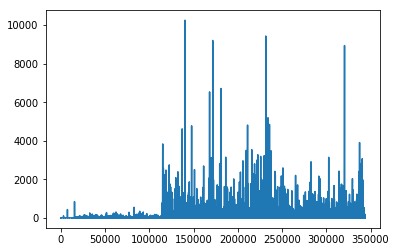

In [10]:
plt.plot(asvGBdf['count'].values)

Now, let's select indicators for each group and create a dictionary. Each group will have 200.000 elements aprox:

In [11]:
NE = 364000

In [12]:
asvGBDict = asvGBdf.to_dict()

In [13]:
acc = 0
f=1 # fold

foldDict = {}
for key, value in asvGBDict['count'].items():
    acc += value
    if (acc > NE):
        acc = 0
        f += 1
    foldDict[key]=f

In [14]:
def setFold(row):
    real_row = row.values
    return foldDict[(real_row[0],real_row[1],real_row[2])]

In [15]:
df['fold'] = df[columns_to_partition].apply(axis=1, func=setFold)

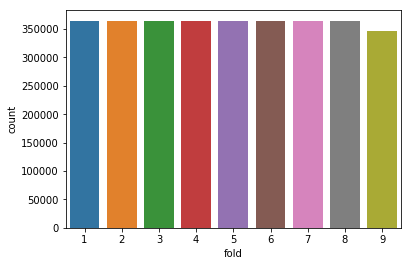

In [16]:
sns.countplot(data=df, x='fold')

We have all this folds to train, let's  get the different files with 50% of data to train the ensembled block:

In [17]:
nFolds = df['fold'].nunique()

In [35]:
for i in range(nFolds):
    print('processing fold ',(i+1),' ... ')
    fold_df = df[df['fold']==(i+1)]
    m=fold_df.shape[0]
    tm = int(m/2)
    ensemble_df = fold_df[0:tm]
    stack_df = fold_df[tm:]
    train_fold_name = 'datasets/train_fold' + str(i+1) + '.csv'
    ensemble_df.drop(labels=['fold'],axis=1,inplace=True)
    ensemble_df.to_csv(train_fold_name)
    if (i == 0):
        stack_complete_df = stack_df.copy()
    else:
        stack_complete_df = pd.concat([stack_complete_df, stack_df])

processing fold  1  ... 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


processing fold  2  ... 
processing fold  3  ... 
processing fold  4  ... 
processing fold  5  ... 
processing fold  6  ... 
processing fold  7  ... 
processing fold  8  ... 
processing fold  9  ... 


In [38]:
stack_complete_df.to_csv('datasets/train_stack.csv')

# End of Analisys! 

After this execution we have the "folded" datasets and the "stacking" dataset!